In [1]:
# Import Basics Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *

In [2]:
# Read in data from CSV
df = pd.read_csv('./Restaurant/Restaurant_Reviews.tsv', sep='\t')
df.columns =['Text', 'Sentiment']
df

,Text,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [3]:
# Check for Null Values
if ( not df.isnull().values.any() ):
    print("Data set has no NULL values.")
else:
    null_tweets = df[df['Tweet'].isnull()].index.tolist()
    print("Null Tweets exist in Training Set. Dropping", len(null_tweets), "rows")
    df.dropna(subset = ["Tweet"], inplace=True)
    print("Null values Exist In X,Y Training Set:", df.isnull().values.any())

Data set has no NULL values.


In [4]:
# Train/Test Split
x = df['Text']
y = df['Sentiment']
TrainXdf,TestXdf, TrainYdf, TestYdf = train_test_split(x, y,test_size=.2, random_state=2)

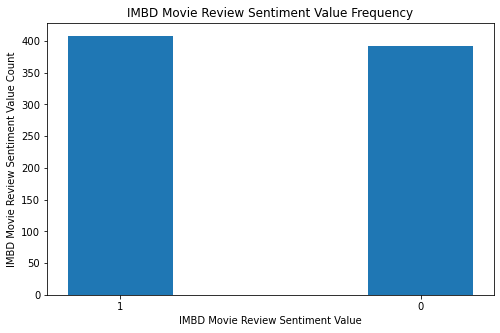

In [5]:
# Visual of Training Samples' Outcomes - Even Distribution of Outcomes
sent_count = TrainYdf.value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)

plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())
plt.xlabel('IMBD Movie Review Sentiment Value')
plt.ylabel('IMBD Movie Review Sentiment Value Count')
plt.title('IMBD Movie Review Sentiment Value Frequency')

plt.show()

In [6]:
# "One-Hot Encoding" Function that converts the Tweets to Numerical Arrays
def oneHotEnc(Tweet):
    token_item = []

    for letter in Tweet:
        if ord(letter) >= ord('a') and ord(letter) <= ord('z'):
            token_item.append(ord(letter) - ord('a'))
        elif letter == ' ':
            token_item.append(-1)
        else:
            pass

    return token_item

# Function that Pre-Processes the Tweets
def PreProcess(tweets, method):
    pre_procc_tweets = []

    # Storing all punctuations using RE library like !;,"% etc
    re_puncs = re.compile('[%s]' % re.escape(string.punctuation))

    # Storing all stop words like a, an, the, when, there, this etc
    stop_word  = set(stopwords.words('english'))

    # Lemmatizing object
    lem = WordNetLemmatizer()

    # Using Porter Stemmer
    p_stem = PorterStemmer()

    for tweet in tweets:
        # Get words in tweet
        words = word_tokenize(str(tweet))

        # Converting all characters to lower case
        words_lower = [w.lower() for w in words]

        # Remove all punctuation
        words_lower_no_punc = [re_puncs.sub('', w) for w in words_lower]

        # Keep only alpha words
        words_lower_alpha = [i for i in words_lower_no_punc if i.isalpha()]

        # Removing all stop words
        words_lower_alpha_nostop = [w for w in words_lower_alpha if w not in stop_word]

        # Doing Lemmatizing of words
        words_lower_alpha_nostop_lemma = [lem.lemmatize(w) for w in words_lower_alpha_nostop]

        # Stemming process
        words_lower_alpha_nostop_lemma_stem = [p_stem.stem(w) for w in words_lower_alpha_nostop_lemma]

        # Convert back to string and (possibly) one-hot encode tweet
        pre_procc_str = ' '.join(words_lower_alpha_nostop_lemma_stem)
        if (method==1):
            procc_tweet = oneHotEnc(pre_procc_str)
        else:
            procc_tweet=pre_procc_str
        pre_procc_tweets.append(procc_tweet)
        
    return pre_procc_tweets

# Encoding method (1 for NGRAM, 0 for TOKENIZATION)
method = 0

# Max Number of features for Tokenization
max_features = 700

# Pre-Process the Tweets and Get Finalized Training and Testing Sets
TrainXdf = PreProcess(TrainXdf,method)
TestXdf = PreProcess(TestXdf,method)

if (method ==0):
    cnt = CountVectorizer(analyzer="word", ngram_range=(1,3), max_features=max_features)
    TrainXdf = cnt.fit_transform(TrainXdf).toarray()
    TestXdf=cnt.transform(TestXdf).toarray()

TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)

print(TrainXdf.shape)
print(TestXdf.shape)

(800, 700)
(200, 700)


In [7]:
# Item Memory Generation Function, NGRAM
def itemMemGen_NGRAM(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    return dictMem
# Item Memory Generation Function, TOKENIZATION
def itemMemGen_TOKEN(features, dim=10000):
    dictMem = np.random.randint(2, size=(features, dim), dtype='int32')
    return dictMem

# Hyperparamaters
HV_dim = 10000
num_supported_chars = 27

# Item Memory Generation
if (method ==1):
    itemMem = itemMemGen_NGRAM(dim=HV_dim, num_char=num_supported_chars)
else:
    itemMem = itemMemGen_TOKEN(features=len(TrainXdf[0]), dim=HV_dim)

In [8]:
# Function for Encoding a Tweet into a HV
def encode(tweet, itemMem, method, HV_dim=10000, n_gram_len=3):
    if (method==1):
        tweet_HV = np.zeros(HV_dim, dtype='int32')

        for ngram_start in range(0, len(tweet)-n_gram_len, 3):
            roll_value=n_gram_len
            for j in range(n_gram_len):
                letterHV = itemMem[tweet[ngram_start + j]]

                if (j==0):
                    product = letterHV
                elif (j==n_gram_len-1):
                    product = product * np.roll(letterHV, roll_value)
                    tweet_HV = np.add(tweet_HV, product)
                else:
                    product = product * np.roll(letterHV, roll_value)
                    
                roll_value = roll_value - 1

        HV_avg = np.average(tweet_HV)
        tweet_HV[tweet_HV > HV_avg] = 1
        tweet_HV[tweet_HV < HV_avg] = -1
        tweet_HV[tweet_HV == HV_avg] = 0
        return tweet_HV
    else:
        return tweet.dot(itemMem)

# HDC Training Function Creates Associative Memory
def train(X, Y, itemMem, HV_dim, sent_count, n_gram_len, method):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    encodedTweets=[]
    tweet_idx = 0
    
    for tweet in X:
        tweet_HV = encode(tweet.reshape(1, len(tweet)), itemMem, method, HV_dim, n_gram_len)
        if (tweet_idx==0):
            print(tweet_HV.shape)
        assocMem[Y[tweet_idx]] = np.add(assocMem[Y[tweet_idx]], tweet_HV)
        tweet_idx += 1

    return assocMem

n_gram_len = 3
assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), n_gram_len, method)
assocMem

(1, 10000)


array([[ 923,  985,  929, ...,  977,  932, 1151],
       [ 852, 1012, 1033, ...,  833,  922, 1133]])

In [9]:
# Function Compares Input HV to Class HVs and Returns the Predicted Class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

# Function Tests the Model and Return Accuracy of Model
def test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method):
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, method, HV_dim, n_gram_len))
        if (TestYdf[index] == prediction):
            correct_count += 1
            
    accuracy = (correct_count / len(TestYdf)) * 100
    return accuracy

# One-Shot Training Results
one_shot_accuracy=test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
print("One Shot Accuracy: ", one_shot_accuracy)

One Shot Accuracy:  76.0


In [10]:
def retrain(X, Y, itemMem, assocMem, HV_dim, n_gram_len, method, alpha):
    tweet_index = 0
    print("start")
    for tweet in X:
        tweet_HV = encode(tweet, itemMem, method, HV_dim, n_gram_len)
        prediction = get_prediction(assocMem, tweet_HV)
        if prediction != Y[tweet_index]:
            assocMem[Y[tweet_index]] = np.add(assocMem[Y[tweet_index]], alpha * tweet_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * tweet_HV)
        tweet_index += 1
        if(tweet_index%10000 == 0):
            print("still going", tweet_index)
    return assocMem

# Re-Train Model
num_epochs = 20
print('-------- Retraining Model: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf ,itemMem, assocMem, HV_dim, n_gram_len, method, alpha = num_epochs - epoch)
    acc = test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
    print('Epoch ', (epoch+1), ': ', acc)

-------- Retraining Model:  20  Epochs --------
start
Epoch  1 :  71.0
start
Epoch  2 :  73.0
start
Epoch  3 :  74.0
start
Epoch  4 :  81.0
start
Epoch  5 :  74.5
start
Epoch  6 :  79.0
start
Epoch  7 :  79.0
start
Epoch  8 :  71.0
start
Epoch  9 :  77.5
start
Epoch  10 :  79.5
start
Epoch  11 :  80.5
start
Epoch  12 :  79.5
start
Epoch  13 :  79.5
start
Epoch  14 :  80.5
start
Epoch  15 :  79.5
start
Epoch  16 :  80.5
start
Epoch  17 :  79.0
start
Epoch  18 :  79.0
start
Epoch  19 :  80.5
start
Epoch  20 :  80.0
